# Maximum Likelihood Estimation

+ Overview
+ Set Up and Assumptions
+ Conditional Distributions
+ Maximum Likelihood Estimation
+ MLE with Numerical Methods
+ Maximum Likelihood Estimation with statsmodels
+ Summary
+ Exercises
+ Solutions

## 1 Overview
在前一节中，我们使用线性回归估计了因变量和解释变量之间的关系

但是如果线性关系不是我们模型的适当假设呢？

一种广泛使用的替代方法是最大似然估计，它涉及指定一类由未知参数索引的分布，然后使用数据锁定这些参数值

相对于线性回归的好处是，它使变量之间的概率关系具有更大的灵活性

我们通过复制丹尼尔·特雷斯曼( 2016 )的论文《俄罗斯的亿万富翁》，说明一个国家的亿万富翁数量与其经济特征相关联的最大可能性

该文得出结论认为，亿万富翁的人数比市场规模和税率等经济因素预测的要多

## 2 Set Up and Assumptions
让我们考虑我们需要在最大似然估计中经历的步骤以及它们与本研究的关系
### Flow of Ideas

最大似然估计的第一步是选择产生数据的概率分布

更确切地说，我们需要假设哪些参数分布类正在生成数据

+ 例如，所有正态分布的类别或所有伽玛分布的类别

每个这样的类是由有限数量的参数索引的分布族

+ 例如，正态分布类是以其均值$\mu \in \left( -\infty ,\infty \right)$和标准差$\sigma \in \left( 0,\infty \right)$为指标的分布   

我们将通过确定参数来让数据挑选出一个特定的元素

这样产生的参数估计将被称为**极大似然估计**

### Counting Billionaires
Treisman [Tre16]对估算不同国家亿万富翁的数量感兴趣

亿万富翁的数量是整数值

因此，我们考虑只在非负整数时才取值的分布

（这是一个原因，最小二乘回归不是目前问题的最佳工具，因为线性回归中的因变量不限于整数值）

一个整数分布是泊松分布，其概率质量函数（pmf）是
$$f(y) = \frac{\mu^{y}}{y!} e^{-\mu}, \qquad y = 0, 1, 2, \ldots, \infty$$

对于不同的μ值，我们可以绘制y上的泊松分布，如下所示

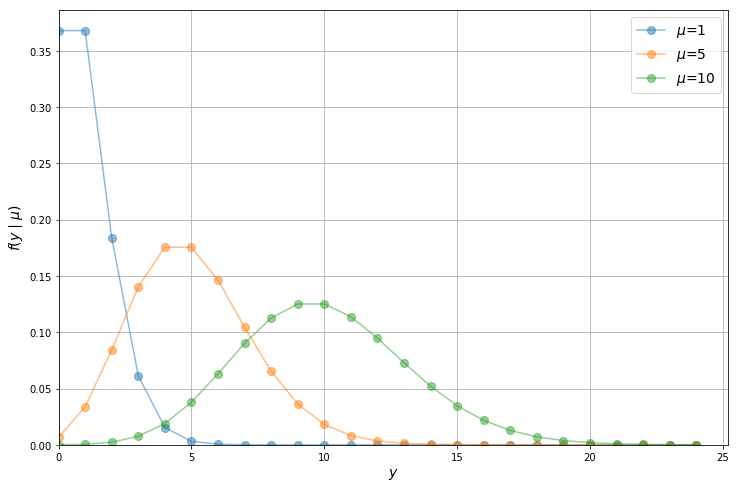

In [1]:
from numpy import exp   #调用指数函数
from scipy.misc import factorial   #阶乘
import matplotlib.pyplot as plt

poisson_pmf = lambda y, mu: mu**y / factorial(y) * exp(-mu)  #lambda作为一个表达式，定义了一个匿名函数
y_values = range(0, 25)

fig, ax = plt.subplots(figsize=(12, 8))  #通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸

for mu in [1, 5, 10]:  
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, mu))
    ax.plot(y_values,
            distribution,
            label=('$\mu$=' + str(mu)), #设置标签
            alpha=0.5, #透明度
            marker='o', #散点的形状为圆标记
            markersize=8)  #散点的大小

ax.grid()  #显示网格
ax.set_xlabel('$y$', fontsize=14)  #设置字体大小
ax.set_ylabel('$f(y \mid \mu)$', fontsize=14)
ax.axis(xmin=0, ymin=0)
ax.legend(fontsize=14)   #设置标签的字体

plt.show()

注意，当y的平均值增加时，泊松分布开始类似于正态分布

让我们来看看我们将在这一讲中使用的数据的分布情况

Treisman的主要数据来源是“福布斯”的亿万富豪年度排名及其估计的净值

In [2]:
import pandas as pd
pd.options.display.max_columns = 10  #显示最大的列数为10列

# Load in data and view
df = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/mle/fp.dta')   
df.head()  #显示变量名称列表，tail()-末尾五行

,country,ccode,year,cyear,numbil,...,topint08,rintr,noyrs,roflaw,nrrents
0,United States,2.0,1990.0,21990.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
1,United States,2.0,1991.0,21991.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
2,United States,2.0,1992.0,21992.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
3,United States,2.0,1993.0,21993.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
4,United States,2.0,1994.0,21994.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN


Using a histogram, we can view the distribution of the number of billionaires per country, $_numbil0_$, in 2008 (the United States is dropped for plotting purposes)

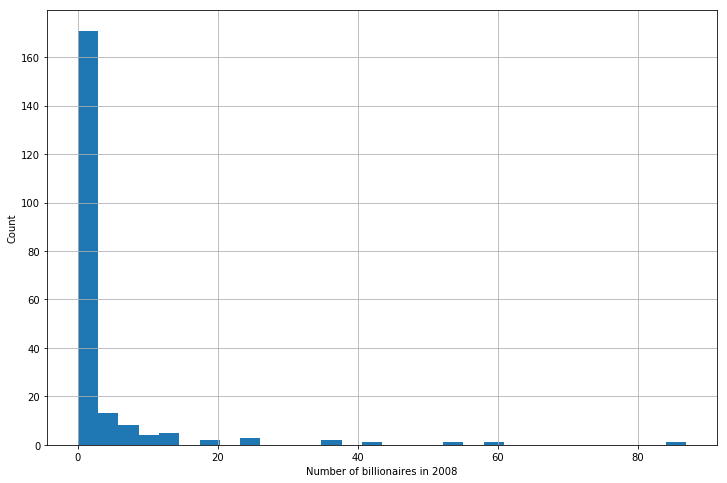

In [3]:
numbil0_2008 = df[(df['year'] == 2008) & (
    df['country'] != 'United States')].loc[:, 'numbil0'] #选取数据

plt.subplots(figsize=(12, 8))  #设置宽高
plt.hist(numbil0_2008, bins=30) #绘直方图的柱数
plt.grid()
plt.xlabel('Number of billionaires in 2008') 
plt.ylabel('Count')
plt.show()

从直方图来看，似乎泊松假设并不是不合理的（尽管 $\mu$ 和一些异常值值很低）

## 3 Conditional Distributions

在Treisman的论文中，因变量 - i国亿万富翁的数量$y_i$ 被模拟为人均GDP，人口规模以及GATT和WTO成员年限的函数

因此，$y_i$ 的分布需要以解释变量$\mathbf{x}_i$为条件

标准公式 - 所谓的泊松回归模型如下：
$$f(y_i \mid \mathbf{x}_i) = \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}; \qquad y_i = 0, 1, 2, \ldots , \infty .$$

$$\text{where}\ \mu_i = \exp(\mathbf{x}_i' \boldsymbol{\beta}) = \exp(\beta_0 + \beta_1 x_{i1} + \ldots + \beta_k x_{ik})$$

为了说明$y_i$的分布依赖于 $\mathbf{x}_i$的想法，让我们运行一个简单的模拟

我们使用上面的`poisson_pmf` 函数和 $\boldsymbol{\beta}$ 和 $\mathbf{x}_i$ 的任意值

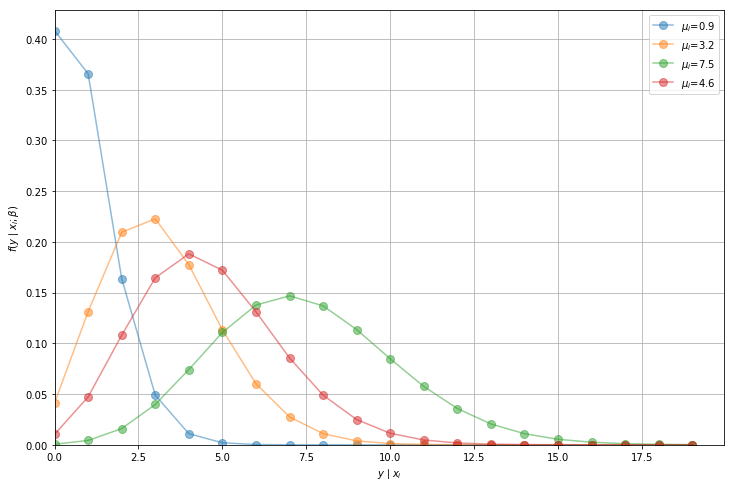

In [4]:
import numpy as np

y_values = range(0, 20)

# Define a parameter vector with estimates
beta = np.array([0.26, 0.18, 0.25, -0.1, -0.22]).T   #转置

# Create some observations X
datasets = [np.array([0, 1, 1, 1, 2]),
            np.array([2, 3, 2, 4, 0]),
            np.array([3, 4, 5, 3, 2]),
            np.array([6, 5, 4, 4, 7])]


fig, ax = plt.subplots(figsize=(12, 8))

for X in datasets:
    mu = exp(X @ beta)
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, mu))
    ax.plot(y_values,
            distribution,
            label=('$\mu_i$=' + str(round(mu, 1))),
            marker='o',
            markersize=8,
            alpha=0.5)

ax.grid()
ax.legend()  #显示图例
ax.set_xlabel('$y \mid x_i$')
ax.set_ylabel('$f(y \mid x_i; \\beta )$')
ax.axis(xmin=0, ymin=0)
plt.show()

我们可以看到，$y_i$ 的分布是以$\mathbf{x}_i$为条件的（$\mu _{i}$不再是常数）

## 4 Maximum Likelihood Estimation

在我们的亿万富豪数量模型中，条件分布包含我们需要估计的4个（k = 4）参数

我们将把整个参数向量标记为$\beta$其中
$$\begin{split}\boldsymbol{\beta} = \begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \\ \beta_3 \\ \end{bmatrix}\end{split}$$

为了用极大似然估计模型，我们希望最大化我们的估计$\widehat {\beta }$是真实参数$\beta$的可能性

直观地说，我们希望找到最适合我们数据的 $\widehat {\beta }$值

首先，我们需要构造似然函数$L\left( \beta \right)$，它类似于联合概率密度函数

假设我们有一些数据 $y_{i}=\left\{ y_{1},y_{2}\right\}$ and $y_{i}\sim f\left( y_{i}\right)$

如果$y_{1}$ 和 $y_{2}$ 是独立的 , 则这些数据的联合概率质量函数是 $f\left( y_{1},y_{2}\right) =f\left( y_{1}\right) \cdot f\left( y_{2}\right)$

如果$y_{i}$服从λ=7泊松分布，我们可以像这样直观地看到联合概率质量函数

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in power


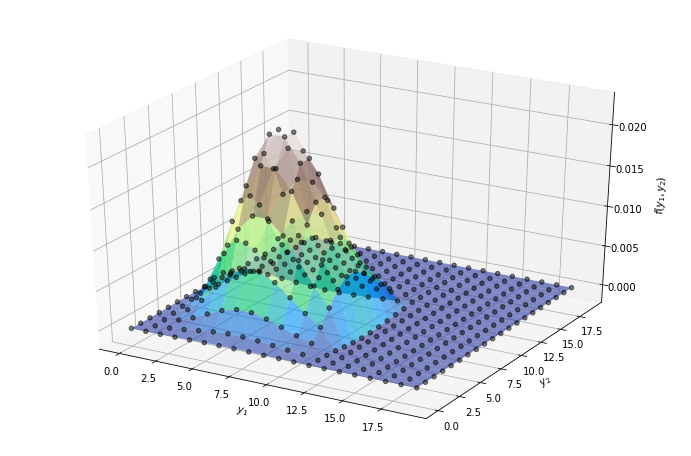

In [5]:
from mpl_toolkits.mplot3d import Axes3D

def plot_joint_poisson(mu=7, y_n=20):
    yi_values = np.arange(0, y_n, 1)

    # Create coordinate points of X and Y
    X, Y = np.meshgrid(yi_values, yi_values) #用两个坐标轴上的点在平面上画格

    # Multiply distributions together
    Z = poisson_pmf(X, mu) * poisson_pmf(Y, mu)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')  #画三维图
    ax.plot_surface(X, Y, Z.T, cmap='terrain', alpha=0.6)  #地形图
    ax.scatter(X, Y, Z.T, color='black', alpha=0.5, linewidths=1)
    ax.set(xlabel='$y_1$', ylabel='$y_2$')
    ax.set_zlabel('$f(y_1, y_2)$', labelpad=10)  #标签与Z轴距离
    plt.show()

plot_joint_poisson(mu=7, y_n=20)

同样，我们数据的联合概率质量函数（作为条件泊松分布）可以写成
$$f\left( y_{1},y_{2},\cdot \ldots ,y_{n}\right| x_{1},x_{2},\ldots ,x_{n};\beta)=\prod^{n}_{i=1}\frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}$$
$y_i$取决于$\mathbf{x}_i$和参数$\beta$ $y_i$的值

似然函数与联合PMF相同，但将参数$\beta$ 视为随机变量，并按照给定的条件进行观测($y_i$,$\mathbf{x}_i$)
$$L\left( \beta \right| y_{1},y_{2},y_{n};x_{1},x_{2},\ldots ,x_{n})=\prod^{n}_{i=1}\frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}=f\left( y_{1},y_{2},\cdot \ldots ,y_{n}\right| x_{1},x_{2},\ldots ,x_{n};\beta)$$
既然我们有了似然函数，我们就要找到产生最大似然值的 $\widehat {\beta }$
$$\max _{\beta }L\left( \beta \right)$$

这样做通常更容易最大化对数似然(考虑区分 $f\left( x\right) =x\exp \left( x\right)$ vs. $f\left( x\right) =\log \left( x\right) +x)$

鉴于取对数是单调递增的变换，似然函数的最大值也将是对数似然函数的最大值

在我们的例子中，对数似然是
$$\begin{eqnarray}\log L\left( \beta \right)&=&\log(f\left( y_{1};\beta \right) \cdot f\left( y_{2};\beta \right)\cdot \cdot \cdot \cdot \cdot f\left( y_{n};\beta \right))\\&=&\sum ^{n}_{i=1}\log f\left( y_{i};\beta \right)\\&=&\sum ^{n}_{i=1}\log(\frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i})\\&=&\sum ^{n}_{i=1}y_{i}\log \mu _{i}-\sum ^{n}_{i=11}\mu _{i}-\sum ^{n}_{i=1}\log y!\end{eqnarray}$$

The MLE of the Poisson to the Poisson for $\widehat {\beta }$ can be obtained by solving
$$\max _{\beta }(\sum ^{n}_{i=1}y_{i}\log \mu _{i}-\sum ^{n}_{i=1}\mu _{i}-\sum ^{n}_{i=1}\log y!)$$
然而，对于上述问题并不存在解析解——要找到最大似然估计，我们需要使用数值方法

## 5 MLE with Numerical Methods
许多分布没有很好的解析解，因此需要数值方法来解决参数估计

一种这样的数值方法是牛顿 - 拉夫逊算法

我们的目标是找到极大似然估计 $\widehat {\beta }$

在 $\widehat {\beta }$处,对数似然函数的一阶导数将等于0

让我们通过假设来说明这一点
$$\log L\left( \beta \right) =-\left( \beta -10\right) ^{2}-10$$

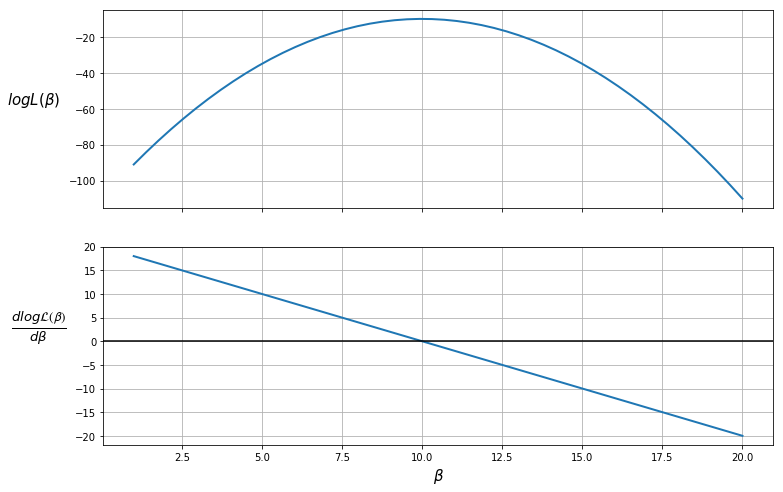

In [6]:
beta = np.linspace(1, 20) #1-20之间的等差数组
logL = -(beta - 10) ** 2 - 10
dlogL = -2 * beta + 20

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8)) #绘制两个子图具有相同的X轴

ax1.plot(beta, logL, lw=2) #线宽
ax2.plot(beta, dlogL, lw=2)

ax1.set_ylabel('$log {L(\\beta)}$',
               rotation=0, #旋转
               labelpad=35,
               fontsize=15)
ax2.set_ylabel(r'$\frac{dlog \mathcal{L(\beta)}}{d \beta}$ ',
               rotation=0,
               labelpad=35,
               fontsize=19)
ax2.set_xlabel('$\\beta$', fontsize=15)
ax1.grid(), ax2.grid()
plt.axhline(c='black')
plt.show()

该图显示，当$\dfrac {d\log L\left( \beta \right) }{d\beta }=0$ 时，出现最大似然值

因此，当$\beta =10$时，可能性最大

我们还可以通过检查二阶导数(底部图的斜率)是否为负来确保此值为最大值

牛顿-拉夫森算法找到一阶导数为0的点

为了使用该算法，我们首先猜测最大值 $\beta_{0}$ (OLS参数估计可能是合理的猜测)，然后

1.Use the updating rule to iterate the algorithm(使用更新规则迭代算法)
$$\beta _{(k+1)} =\beta _{(k)}-\dfrac {G\left( \beta _{(k)} \right) }{H\left( \beta _{(k)}\right) }$$
where:
$$G\left( \beta _ {(k)}\right) =\dfrac {d\log L\left( \beta_ {(k)} \right) }{d\beta_ {(k)} }$$
$$H\left( \beta _ {(k)}\right) =\dfrac {d^{2}\log L\left( \beta _{(k)}\right) }{d\beta ^{2}_{(k)}}$$

2.Check whether  $\beta _{(k+1)}-\beta _{(k)}<tol$
+ If true, then stop iterating and set $\widehat {\beta }=\beta _{(k+1)}$
+ If false, then update $\beta _{(k+1)}$

从方程可以看出，仅当$G\left( \beta _{(k)}\right)=0$时，$\beta _{(k+1)}=\beta _{(k)}$，即一阶导数等于0

(在实践中，当差值低于一个小误差值时，我们停止迭代)

让我们开始实现牛顿-拉夫森算法

首先，我们将创建一个名为 `PoissonRegression`的类，以便我们可以轻松地重新计算每次迭代的对数似然，梯度和海塞矩阵

In [7]:
class PoissonRegression: 

    def __init__(self, y, X, beta):  #初始化创建对象的状态
        self.X, self.y, self.beta = X, y, beta
        self.n, self.k = X.shape  #shape表示数组的每个方向上的维度

    def mu(self):
        return np.exp(np.dot(self.X, self.beta.T)) #矩阵相乘

    def logL(self):
        y = self.y
        mu = self.mu()
        return np.sum(y*np.log(mu) - mu - np.log(factorial(y)))

    def G(self):
        mu = self.mu()
        return np.dot(self.y - mu, self.X).reshape(self.k, 1)  #reshape:给予数组一个新的形状，而不改变它的数据


    def H(self):
        X = self.X
        mu = self.mu()
        return -np.dot(mu * X.T, X)

我们的函数`newton_raphson` 将采用一个`PoissonRegression`对象，该对象初始猜测参数向量$\beta _{0}$

该算法根据更新规则更新参数向量，并在新的参数估计下重新计算梯度矩阵和海塞矩阵

迭代将在以下任一情况下结束:

+ 参数和更新的参数之间的差异低于精度水平
+ 已达到最大迭代次数(意味着未达到收敛)

因此，我们可以了解算法运行时的情况，并在每次迭代中添加选项display = True以打印出值

In [8]:
def newton_raphson(model, tol=1e-3, max_iter=1000, display=True):#牛顿迭代法，精度0.001，迭代次数是1000

    i = 0
    error = 100  # Initial error value
    format_string = "{i:<13}{l:<16}{t:<30}" #格式化字符串

    # Print header of output
    if display:
        header = format_string.format(i="Iteration_k", l="Log-likelihood", t="Theta")
        print(header)
        print("-" * len(header))

    # While loop runs while any value in error is greater
    # than the tolerance until max iterations are reached（当循环运行时，任何错误值都较大 直到达到最大迭代）
    while np.any(error > tol) and i < max_iter:
        H, G = model.H(), model.G()
        beta_new = model.beta - (np.linalg.inv(H) @ G).T #np.linalg.inv（矩阵求逆）
        error = beta_new - model.beta
        model.beta = beta_new.flatten() #返回一个折叠成一维的数组

        # Print iterations
        if display:
            beta_list = ['%.4f' % t for t in list(np.round(model.beta, 3))]  # 小数点后精度4位，round返回浮点数x的四舍五入值，返回小数点四舍五入到3个数字
            update = format_string.format(i=i, l=round(model.logL(), 8), t=str(beta_list))
            print(update)

        i += 1

    print('Number of iterations: ' + str(i))
    print('beta_hat = ' + str(model.beta))

    return model.beta

让我们用X中的5个观察值和3个变量的小数据集来试验我们的算法

In [9]:
X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

# Take a guess at initial betas
init_beta = np.array([0.1, 0.1, 0.1])

# Create an object with Poisson model values(用泊松模型值创建一个对象)
poi = PoissonRegression(y, X, beta=init_beta)

# Use newton_raphson to find the MLE
beta_hat = newton_raphson(poi, display=True)

Iteration_k  Log-likelihood  Theta                         
-----------------------------------------------------------
0            -4.34476224     ['-1.4890', '0.2650', '0.2440']
1            -3.5742413      ['-3.3840', '0.5280', '0.4740']
2            -3.39995256     ['-5.0640', '0.7820', '0.7020']
3            -3.37886465     ['-5.9150', '0.9090', '0.8200']
4            -3.3783559      ['-6.0740', '0.9330', '0.8430']
5            -3.37835551     ['-6.0780', '0.9330', '0.8430']
Number of iterations: 6
beta_hat = [-6.07848205  0.93340226  0.84329625]


由于这是一个观测数量很少的简单模型，该算法仅在6次迭代中实现了收敛

可以看到，每次迭代时，对数似然值都会增加

记住，我们的目标是最大化对数似然函数，算法已经实现

还要注意，$logL\left( \beta _{(k)}\right)$ 的增加随着每次迭代而变小

这是因为当我们达到最大值时梯度接近0，因此我们更新方程中的分子变得更小

在 $\widehat {\beta }$处梯度向量应该接近于0

In [10]:
poi.G()

array([[ -3.95169229e-07],
       [ -1.00114805e-06],
       [ -7.73114567e-07]])

迭代过程可以在下图中看到，其中最大值在$\beta=10$处找到

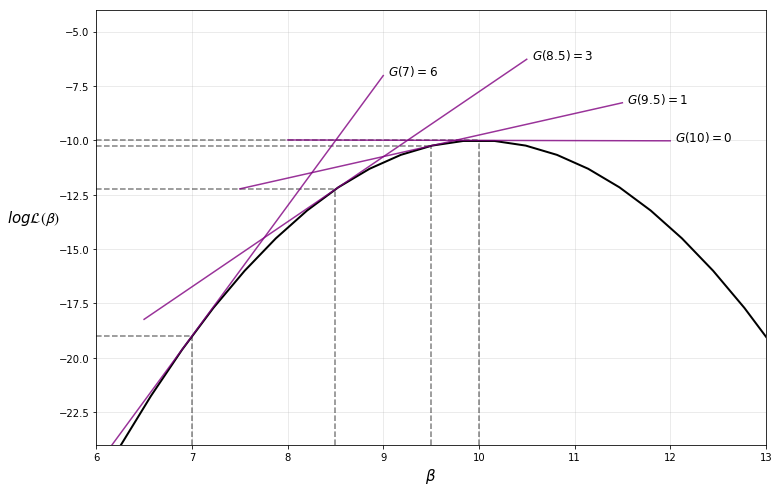

In [11]:
logL = lambda x: -(x - 10) ** 2 - 10

def find_tangent(beta, a=0.01):  #正切
    y1 = logL(beta)
    y2 = logL(beta+a)
    x = np.array([[beta, 1], [beta+a, 1]])
    m, c = np.linalg.lstsq(x, np.array([y1, y2]))[0] #最小二乘法解出斜率和截距
    return m, c

beta = np.linspace(2, 18)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(beta, logL(beta), lw=2, c='black')

for beta in [7, 8.5, 9.5, 10]:
    beta_line = np.linspace(beta-2, beta+2)
    m, c = find_tangent(beta)
    y = m*beta_line + c
    ax.plot(beta_line, y, '-', c='purple', alpha=0.8) #紫色
    ax.text(beta+2.05, y[-1], r'$G({}) = {:.0f}$'.format(beta, abs(m)), fontsize=12)
    ax.vlines(beta, -24, logL(beta), linestyles='--', alpha=0.5)  #线条风格
    ax.hlines(logL(beta), 6, beta, linestyles='--', alpha=0.5)

ax.set(ylim=(-24, -4), xlim=(6, 13)) #坐标区间的设定
ax.set_xlabel('$\\beta$', fontsize=15)
ax.set_ylabel('$log \mathcal{L(\\beta)}$',
               rotation=0,
               labelpad=25,
               fontsize=15)
ax.grid(alpha=0.3)
plt.show()

## 6 Maximum Likelihood Estimation with `statsmodels`
我们可以将MLE应用于一个有趣的应用程序

我们将使用`statsmodels` 中的泊松回归模型来获得更丰富的输出，包括标准误差、测试值等

`statsmodels` 使用与上面相同的算法来查找最大似然估计值

在开始之前，让我们用`statsmodels`重新估计我们的简单模型，以确认我们获得相同的系数和对数似然值

In [12]:
from statsmodels.api import Poisson #Statsmodels是Python的统计建模和计量经济学工具包，包括一些描述统计、统计模型估计和推断
from scipy import stats #stats模块包含了多种概率分布的随机变量，随机变量分为连续的和离散的两种
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df) #卡方检验

X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

stats_poisson = Poisson(y, X).fit()
print(stats_poisson.summary())

Optimization terminated successfully.
         Current function value: 0.675671
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                    5
Model:                        Poisson   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Sun, 22 Apr 2018   Pseudo R-squ.:                  0.2546
Time:                        01:47:06   Log-Likelihood:                -3.3784
converged:                       True   LL-Null:                       -4.5325
                                        LLR p-value:                    0.3153
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -6.0785      5.279     -1.151      0.250       -16.425     4.268
x1             0.9334      0.

现在让我们复制丹尼尔·特雷斯曼的论文《俄罗斯的亿万富翁》中的结果

Treisman starts by estimating equation (1), where:
+ $y_{i}$ is number of $billionaires_{i}$
+ $x_{i1}$ is log GDP per $capita_{i}$
+ $x_{i2}$ is log $⁡population_{i}$
+ $x_{i3}$ is years in $GATT_{i}$-years membership in GATT and WTO (to proxy access to international markets)
The paper only considers the year 2008 for estimation

We will set up our variables for estimation like so (you should have the data assigned to $_df_$ from earlier in the lecture)

In [13]:
# Keep only year 2008
df = df[df['year'] == 2008]

# Add a constant
df['const'] = 1

# Variable sets
reg1 = ['const', 'lngdppc', 'lnpop', 'gattwto08']
reg2 = ['const', 'lngdppc', 'lnpop',
        'gattwto08', 'lnmcap08', 'rintr', 'topint08']
reg3 = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08',
        'rintr', 'topint08', 'nrrents', 'roflaw']

Then we can use the $_Poisson_$ function from $_statsmodels_$ to fit the model

We’ll use robust standard errors as in the author’s paper

In [14]:
import statsmodels.api as sm

# Specify model
poisson_reg = sm.Poisson(df[['numbil0']], df[reg1],
                         missing='drop').fit(cov_type='HC0')#HC0
print(poisson_reg.summary())

         Current function value: 2.226090
         Iterations: 35
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Sun, 22 Apr 2018   Pseudo R-squ.:                  0.8574
Time:                        01:47:06   Log-Likelihood:                -438.54
converged:                      False   LL-Null:                       -3074.7
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000       -34.103   -23.997
lngdppc        1.0839      0.138      7.834      0.000         0.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Here we received a warning message saying “Maximum number of iterations has been exceeded.”

Let’s try increasing the maximum number of iterations that the algorithm is allowed (the .$_fit()_$ docstring tells us the default number of iterations is 35)

In [15]:
poisson_reg = sm.Poisson(df[['numbil0']], df[reg1],
                         missing='drop').fit(cov_type='HC0', maxiter=100)
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 36
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Sun, 22 Apr 2018   Pseudo R-squ.:                  0.8574
Time:                        01:47:06   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000       -34.103   -23.997
lngdppc        1.0839      0

该算法能在36次迭代中实现收敛

从表中可以看出，人均国内生产总值、人口和加入关贸总协定的年数与一个国家的亿万富翁人数正相关

让我们也估算一下更全面的模型，并将其显示在一个表中

In [16]:
from statsmodels.iolib.summary2 import summary_col

regs = [reg1, reg2, reg3]
reg_names = ['Model 1', 'Model 2', 'Model 3']
info_dict = {'Pseudo R-squared': lambda x: "{:.2f}".format(x.prsquared),
             'No. observations': lambda x: "{0:d}".format(int(x.nobs))}
regressor_order = ['const',
                   'lngdppc',
                   'lnpop',
                   'gattwto08',
                   'lnmcap08',
                   'rintr',
                   'topint08',
                   'nrrents',
                   'roflaw']
results = []

for reg in regs:
    result = sm.Poisson(df[['numbil0']], df[reg],
                        missing='drop').fit( cov_type='HC0',maxiter=100, disp=0) #不显示迭代次数
    results.append(result)

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('Table 1 - Explaining the Number of Billionaires in 2008')
print(results_table)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\iolib\summary2.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\iolib\summary2.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\iolib\summary2.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 

Table 1 - Explaining the Number of Billionaires in 2008
                  Model 1    Model 2    Model 3  
-------------------------------------------------
const            -29.050*** -19.444*** -20.858***
                 (2.578)    (4.820)    (4.255)   
lngdppc          1.084***   0.717***   0.737***  
                 (0.138)    (0.244)    (0.233)   
lnpop            1.171***   0.806***   0.929***  
                 (0.097)    (0.213)    (0.195)   
gattwto08        0.006      0.007      0.004     
                 (0.007)    (0.006)    (0.006)   
lnmcap08                    0.399**    0.286*    
                            (0.172)    (0.167)   
rintr                       -0.010     -0.009    
                            (0.010)    (0.010)   
topint08                    -0.051***  -0.058*** 
                            (0.011)    (0.012)   
nrrents                                -0.005    
                                       (0.010)   
roflaw                                 0.203

结果表明，亿万富豪的频率与人均GDP，人口规模，股票市值正相关，与最高边际所得税率呈负相关

要按国家分析我们的结果，我们可以绘制预测值与实际值之间的差值，然后从最高到最低排序并绘制前15个值

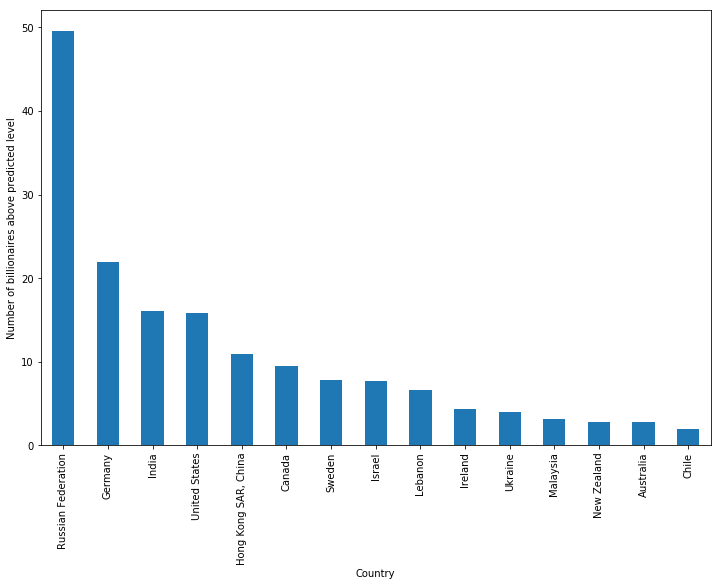

In [17]:
data = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08', 'rintr',
        'topint08', 'nrrents', 'roflaw', 'numbil0', 'country']
results_df = df[data].dropna() #丢掉所有含有空元素的数据

# Use last model (model 3)
results_df['prediction'] = results[-1].predict()

# Calculate difference
results_df['difference'] = results_df['numbil0'] - results_df['prediction']

# Sort in descending order
results_df.sort_values('difference', ascending=False, inplace=True) #降序  inplace=True：不创建新的对象，直接对原始对象进行修改

# Plot the first 15 data points
results_df[:15].plot('country', 'difference', kind='bar', figsize=(12,8), legend=False)
plt.ylabel('Number of billionaires above predicted level')
plt.xlabel('Country')
plt.show()

正如我们所见，俄罗斯亿万富翁的数量远远超过了模型的预测(比预期多50人左右)

treisman利用这一实证结果讨论了俄罗斯亿万富翁人数过多的可能原因，包括俄罗斯财富的来源、政治气候以及苏联后几年私有化的历史

## 7 Summary

In this lecture we used Maximum Likelihood Estimation to estimate the parameters of a Poisson model

`statsmodels` contains other built-in likelihood models such as $Probit$ and $Logit$

For further flexibility, `statsmodels` provides a way to specify the distribution manually using the `GenericLikelihoodModel` class - an example notebook can be found here

## 8 Exercises

### Exercises1
Suppose we wanted to estimate the probability of an event $y_{i}$ occurring, given some observations

We could use a probit regression model, where the pmf of $y_{i}$ is
$$f\left( y_{i};\beta \right)=\mu_i^{y_i}\left( 1-\mu _{i}\right) ^{1-y_{i}},  y_{i}=0,1$$
where $$\mu _{i}=\Phi \left( x_{i}'\beta \right)$$

$\Phi$ represents the cumulative normal distribution and constrains the predicted $y_{i}$ to be between 0 and 1 (as required for a probability)

$\beta$ is a vector of coefficients

Following the example in the lecture, write a class to represent the Probit model

To begin, find the log-likelihood function and derive the gradient and Hessian

The `scipy` module `stats.norm` contains the functions needed to compute the cmf and pmf of the normal distribution

In [18]:
from scipy.stats import norm

class ProbitRegression:

    def __init__(self, y, X, beta):
        self.X, self.y, self.beta = X, y, beta
        self.n, self.k = X.shape

    def mu(self):
        return norm.cdf(np.dot(self.X, self.beta.T))

    def phi(self):
        return norm.pdf(np.dot(self.X, self.beta.T))

    def logL(self):
        mu = self.mu()
        return np.sum(y * np.log(mu) + (1-y) * np.log(1-mu))

    def G(self):
        mu = self.mu()
        phi = self.phi()
        return np.sum((X.T * y*phi/mu - X.T * (1-y)*phi/(1-mu)), axis=1)

    def H(self):
        X = self.X
        beta = self.beta
        mu = self.mu()
        phi = self.phi()
        a = (phi + np.dot(X, beta.T) * mu) / mu**2
        b = (phi - np.dot(X, beta.T) * (1 - mu)) / (1-mu)**2
        return -np.dot(phi * (y*a + (1-y)*b) * X.T, X)

### Exercise 2
Use the following dataset and initial values of $\beta$ to estimate the MLE with the Newton-Raphson algorithm developed earlier in the lecture
$$X=\begin{bmatrix} 1 & 2 & 4 \\ 1 & 1 & 1 \\ 1 & 4 & 3 \\ 1 & 5 & 6 \\ 1 & 3 & 5 \end{bmatrix},  y=\begin{bmatrix} 1 \\ 0 \\ 1 \\ 1 \\ 0 \end{bmatrix},  \beta _{(0)}=\begin{bmatrix} 0.1 \\ 0.1 \\ 0.1 \end{bmatrix}$$
Verify your results with `statsmodels` - you can import the Probit function with the following import statement

from statsmodels.discrete.discrete_model import Probit

Note that the simple Newton-Raphson algorithm developed in this lecture is very sensitive to initial values, and therefore you may fail to achieve convergence with different starting values

In [19]:
X = np.array([[1, 2, 4],
              [1, 1, 1],
              [1, 4, 3],
              [1, 5, 6],
              [1, 3, 5]])

y = np.array([1, 0, 1, 1, 0])

# Take a guess at initial betas
beta = np.array([0.1, 0.1, 0.1])

# Create instance of Probit regression class
prob = ProbitRegression(y, X, beta)

# Run Newton-Raphson algorithm
newton_raphson(prob)

Iteration_k  Log-likelihood  Theta                         
-----------------------------------------------------------
0            -2.37968841     ['-1.3400', '0.7750', '-0.1570']
1            -2.36875259     ['-1.5350', '0.7750', '-0.0980']
2            -2.36872942     ['-1.5460', '0.7780', '-0.0970']
3            -2.36872942     ['-1.5460', '0.7780', '-0.0970']
Number of iterations: 4
beta_hat = [-1.54625858  0.77778952 -0.09709757]


array([-1.54625858,  0.77778952, -0.09709757])

In [20]:
from statsmodels.discrete.discrete_model import Probit

In [21]:
# Use statsmodels to verify results

print(Probit(y, X).fit().summary())

Optimization terminated successfully.
         Current function value: 0.473746
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                    5
Model:                         Probit   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Sun, 22 Apr 2018   Pseudo R-squ.:                  0.2961
Time:                        01:47:08   Log-Likelihood:                -2.3687
converged:                       True   LL-Null:                       -3.3651
                                        LLR p-value:                    0.3692
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -1.5463      1.866     -0.829      0.407        -5.204     2.111
x1             0.7778      0.